In [1]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from numba import njit

In [2]:
basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/psderiv/'

In [3]:
sn = arepo.Snapshot(basepath + 'iso/runs/Nbody/lvl3/output', 500, combineFiles=True)

In [4]:
center = sn.part1.pos.value[np.argmin(sn.part1.pot.value)]
pos = sn.part2.pos.value - center
mass = np.full(sn.NumPart_Total[2], sn.MassTable[2])
vel = sn.part2.vel.value
acc = sn.part2.acce

In [260]:
sn1 = arepo.Snapshot(basepath + 'iso/runs/Nbody/lvl3/output', 501, combineFiles=True)

In [241]:
center1 = sn1.part1.pos.value[np.argmin(sn1.part1.pot.value)]
pos1 = sn1.part2.pos.value - center1
mass1 = np.full(sn1.NumPart_Total[2], sn1.MassTable[2])
vel1 = sn1.part2.vel.value
acc1 = sn1.part2.acce

In [259]:
sn2 = arepo.Snapshot(basepath + 'iso/runs/Nbody/lvl3/output', 502, combineFiles=True)

In [261]:
center2 = sn2.part1.pos.value[np.argmin(sn2.part1.pot.value)]
pos2 = sn2.part2.pos.value - center2
mass2 = np.full(sn2.NumPart_Total[2], sn2.MassTable[2])
vel2 = sn2.part2.vel.value
acc2 = sn2.part2.acce

In [8]:
def generate_bins(pos,
                  Nmin=4000,
                  Nmax=32000,
                  DexBin=0.1):
    R = np.linalg.norm(pos[:,:2], axis=1)
    R = R[np.argsort(R)]
    
    bins = []
    
    Rmin = 0
    i = Nmin - 1
    Rmax = R[i]
    bins.append([Rmin, Rmax])
    
    # create first set of bins
    
    while Rmax < 10:
        Rmin = R[i+1]
        
        Rmax_ = 10.**(DexBin) * Rmin
        key_Rmax = np.where(R < Rmax_)[0]
        Rmax = R[key_Rmax[-1]]
        N = len(np.where(np.logical_and(R >= Rmin, R <= Rmax))[0])
        
        if N < Nmin:
            Rmax = R[i+Nmin]
            N = Nmin
        elif N > Nmax:
            Rmax = R[i+Nmax]
            N = Nmax
        
        bins.append([Rmin, Rmax])
        i = i + N - 1
    
    bins_with_int = []
    
    # second interleaving set of bins
    for i in range(len(bins)-1):
        bin0 = bins[i]
        bin1 = bins[i+1]
        
        Rmin = (bin0[0] + bin0[1])/2.
        Rmax = (bin1[0] + bin1[1])/2.
    
        bins_with_int.append(bin0)
        bins_with_int.append([Rmin, Rmax])
    
    bins_with_int.append(bin1)
    
    return bins_with_int

In [9]:
def Fourier_analysis(pos, mass, bins):
    R = np.linalg.norm(pos[:,:2], axis=1)
    
    cphi = pos[:,0]/R
    sphi = pos[:,1]/R
    c2phi = (pos[:,0]**2 - pos[:,1]**2)/R**2
    s2phi = 2*pos[:,0]*pos[:,1]/R**2
    
    Sigma2_bins = []
    Sigma0_bins = []
    phi2_bins = []
    R_bins = []
    
    for Rmin, Rmax in bins:
        key = np.logical_and(R >= Rmin, R <= Rmax)
        C2 = np.sum(mass[key] * c2phi[key])
        S2 = np.sum(mass[key] * s2phi[key])
        
        Sigma2 = np.sqrt(C2**2 + S2**2)
        Sigma0 = np.sum(mass[key])
        phi2 = 0.5 * np.arctan2(S2, C2)
        
        R_bins.append(np.mean(R[key]))
        
        Sigma2_bins.append(Sigma2)
        Sigma0_bins.append(Sigma0)
        phi2_bins.append(phi2)
    
    R_bins = np.array(R_bins)
    Sigma2_bins = np.array(Sigma2_bins)
    Sigma0_bins = np.array(Sigma0_bins)
    phi2_bins = np.array(phi2_bins)
    
    return R_bins, Sigma2_bins, Sigma0_bins, phi2_bins

In [10]:
def identify_bar_region(bins, A2, phi2,
                        bar_A2_thresh=0.2, Dphi2_thresh=10*np.pi/180.,
                        min_A2_thresh=0.05):
    
    A2max = np.max(A2)

    if A2max < bar_A2_thresh:
        is_barred = False
        return is_barred, np.nan, np.nan, A2max, np.nan
    else:
        is_barred = True
    
    lower_i = np.argmax(A2)
    upper_i = lower_i
    
    phi2_list = [phi2[lower_i]]
    Dphi2 = 0.0
    phi2_mean = phi2[lower_i]
    
    while True:
        lower_i_ = lower_i - 1
        upper_i_ = upper_i + 1
        
        lower_eligible = A2[lower_i_] > A2max/2.
        upper_eligible = A2[upper_i_] > A2max/2.
        
        phi2_mean = np.mean(phi2_list)
        
        if lower_eligible and upper_eligible:
            phi2_lower = phi2[lower_i_]
            phi2_upper = phi2[upper_i_]
            
            if np.abs(phi2_upper - phi2_mean) < np.abs(phi2_lower - phi2_mean):
                phi2_list.append(phi2_upper)
                Dphi2 = np.max(phi2_list) - np.min(phi2_list)
                if Dphi2 < Dphi2_thresh:
                    upper_i = upper_i_
                    continue
                else:
                    break
            else:
                phi2_list.append(phi2_lower)
                Dphi2 = np.max(phi2_list) - np.min(phi2_list)
                if Dphi2 < Dphi2_thresh:
                    lower_i = lower_i_
                    continue
                else:
                    break
        
        if lower_eligible and not upper_eligible:
            phi2_list.append(phi2_lower)
            Dphi2 = np.max(phi2_list) - np.min(phi2_list)
            if Dphi2 < Dphi2_thresh:
                lower_i = lower_i_
                continue
            else:
                break
                
        if upper_eligible and not lower_eligible:
            phi2_list.append(phi2_upper)
            Dphi2 = np.max(phi2_list) - np.min(phi2_list)
            if Dphi2 < Dphi2_thresh:
                upper_i = upper_i_
                continue
            else:
                break
        
        if not upper_eligible and not lower_eligible:
            break
    
    Rmin = bins[lower_i][0]
    Rmax = bins[upper_i][1]
    
    return is_barred, Rmin, Rmax, A2max, phi2_mean
    

In [11]:
@njit
def window(x, R0, R1):

    Rm = (R0+R1)/2
    L = (R1-R0)/2
    
    W = np.zeros(x.shape)
    
    for i in range(len(x)):
        if x[i] < (R0+1e-12) or x[i] > (R1-1e-12):
            W[i] = 0.0
        else:
            W[i] = np.exp(-1/(1-((x[i]-Rm)/L)**2))
    
    return W

@njit
def grad_window(x, R0, R1):
    
    Rm = (R0+R1)/2
    L = (R1-R0)/2
    
    dW = np.zeros(x.shape)
    
    for i in range(len(x)):
        if x[i] < (R0+1e-12) or x[i] > (R1-1e-12):
            dW[i] = 0.0
        else:
            dW[i] = np.exp(-1/(1-((x[i]-Rm)/L)**2))
            dW[i] *= -2*L**2*(x[i]-Rm)
            dW[i] /= (L**2-(x[i]-Rm)**2)**2
    
    # ans[np.logical_or(x<R0, x>R1)] = 0
    # ans[np.logical_or(x<(R0+1e-12), x>(R1-1e-12))] = 0
    
    return dW

@njit
def grad2_window(x, R0, R1):
    
    Rm = (R0+R1)/2
    L = (R1-R0)/2
    
    ddW = np.zeros(x.shape)
    
    for i in range(len(x)):
        if x[i] < (R0+1e-12) or x[i] > (R1-1e-12):
            ddW[i] = 0.0
        else:
            ddW[i] = np.exp(-1/(1-((x[i]-Rm)/L)**2))
            ddW[i] *= -2 * L**2 * (L**4 - 3*(x[i]-Rm)**4)
            ddW[i] /= (L**2-(x[i]-Rm)**2)**4
    
    return ddW

In [12]:
def rotate_pos(pos, ang):

    Rmat = np.array([[np.cos(ang), -np.sin(ang), 0.0],
                     [np.sin(ang),  np.cos(ang), 0.0],
                     [0.0,         0.0,          1.0]])
    
    pos = np.swapaxes(pos, 0, 1)
    pos = np.matmul(Rmat, pos)
    pos = np.swapaxes(pos, 0, 1)
    
    return pos

In [32]:
def compute_pattern_speed(pos, vel, acc, mass, R0, R1, phi2):
    # compute R
    print(phi2)
    pos = rotate_pos(pos, -phi2)
    vel = rotate_pos(vel, -phi2)
    acc = rotate_pos(acc, -phi2)

    R = np.linalg.norm(pos[:,:2], axis=1)
    vmag = np.linalg.norm(vel, axis=1)
    
    # compute cos and sin terms
    # cphi = pos[:,0]/R
    # sphi = pos[:,1]/R
    # c2phi = (pos[:,0]**2 - pos[:,1]**2)/R**2
    # s2phi = 2*pos[:,0]*pos[:,1]/R**2
    phi = np.arctan2(pos[:,1], pos[:,0])
    cphi = np.cos(phi)
    sphi = np.sin(phi)
    c2phi = np.cos(2*phi)
    s2phi = np.sin(2*phi)
    
    # compute vel and acc in cylindrical coordinates
    velR = vel[:,0] * cphi + vel[:,1] * sphi
    velphi = - vel[:,0] * sphi + vel[:,1] * cphi
    
    accR = acc[:,0] * cphi + acc[:,1] * sphi
    accphi = - acc[:,0] * sphi + acc[:,1] * cphi
    
    # compute window functions
    W = window(R, R0, R1)
    dW = grad_window(R, R0, R1)
    ddW = grad2_window(R, R0, R1)
    
    # compute C2, S2, Cdot2, and Sdot2
    C2 = np.sum(mass * W * c2phi)
    S2 = np.sum(mass * W * s2phi)
    
    Cdot2 = np.sum(mass * (velR*dW*c2phi - 2 * (velphi/R) * W * s2phi))
    Sdot2 = np.sum(mass * (velR*dW*s2phi + 2 * (velphi/R) * W * c2phi))
    
    # compute pattern speed from C, S terms
    Omegap = 0.5 * (C2*Sdot2 - S2*Cdot2) / (C2**2 + S2**2)
    
    #compute Cddot2, Sddot2
#     denom = 2. * np.sum(mass * W * s2phi)
    
#     term1 = -4 * Omegap**2 * np.sum(mass * W * c2phi)
#     term2 = np.sum(mass * vmag**2 * c2phi * dW / R)
#     term3 = np.sum(mass * vmag**2 * c2phi * ddW)
#     term4 = - 4 * np.sum(mass * vmag**2 * c2phi * W / R**2)
#     term5 = - np.sum(mass * accR * c2phi * dW)
#     term6 = 2 * np.sum(accphi * s2phi * W / R)
    
#     Omegapdot = (term1 + term2 + term3 + term4 + term5 + term6)/denom
#     print('term1: ', term1)
#     print('term2: ', term2)
#     print('term3: ', term3)
#     print('term4: ', term4)
#     print('term5: ', term5)
#     print('term6: ', term6)
#     print('denom: ', denom)
    
    
    C = 2 * np.sum(mass * W * s2phi)
    D = 2 * np.sum(mass * W * c2phi)
    
    A1 = -4*Omegap**2 * np.sum(mass * c2phi * W)
    A2 = np.sum(mass *vmag**2 * c2phi * dW / R)
    A3 = np.sum(mass * vmag**2 * c2phi * ddW)
    A4 = -4 * np.sum(mass * vmag**2 * c2phi * W / R**2)
    A5 = - np.sum(mass * accR * c2phi * dW)
    A6 = 2 * np.sum(mass * accphi * s2phi * W / R)
    A = A1 + A2 + A3 + A4 + A5 + A6
    
    B1 = 4*Omegap**2 * np.sum(mass * s2phi * W)
    B2 = -np.sum(mass *vmag**2 * s2phi * dW / R)
    B3 = -np.sum(mass * vmag**2 * s2phi * ddW)
    B4 = 4 * np.sum(mass * vmag**2 * s2phi * W / R**2)
    B5 = np.sum(mass * accR * s2phi * dW)
    B6 = 2 * np.sum(mass * accphi * c2phi * W / R)
    B = B1 + B2 + B3 + B4 + B5 + B6
    
    Omegapdot = (A*C + B*D) / (C**2 + D**2)
    
    # print('C2:', C2)
    # print('S2:', S2)
    # print('Cdot2:', Cdot2)
    # print('Sdot2:', Sdot2)
    # print('Cddot2:', Cddot2)
    # print('Sddot2:', Sddot2)
    
    return Omegap, Omegapdot
    

In [23]:
%%time
bins = generate_bins(pos)
R, Sigma2, Sigma0, phi2 = Fourier_analysis(pos, mass, bins)
is_barred, R0, R1, A2max, phi2_mean = identify_bar_region(bins, Sigma2/Sigma0, phi2)
ps, psdot = compute_pattern_speed(pos, vel, acc, mass, R0, R1, phi2_mean)
print(R0, R1)
print(ps, psdot)
print(-psdot/ps**2)

1.2315247386069543 4.37678360878015
36.62150613596706 3071.596692715828
-2.2902969149897343
CPU times: user 14.6 s, sys: 2.87 s, total: 17.5 s
Wall time: 17.6 s


In [33]:
ps, psdot = compute_pattern_speed(pos, vel, acc, mass, R0, R1, phi2_mean)
print(ps, psdot)
print(-psdot/ps**2)

1.180063268120727
36.621506135966996 3071.596692715821
-2.290296914989737


In [268]:
bins = generate_bins(pos1)
R, Sigma2, Sigma0, phi2 = Fourier_analysis(pos1, mass1, bins)
is_barred, R01, R11, A2max1, phi2_mean1 = identify_bar_region(bins, Sigma2/Sigma0, phi2)
ps, psdot = compute_pattern_speed(pos1, vel1, acc1, mass1, R01, R11, phi2_mean1)
# print(R0, R1)
print(ps, psdot)
print(-psdot/ps**2)

C2: -0.10593755319302545
S2: 0.03427574948724319
Cdot2: -2.648782640261213
Sdot2: -7.737411995630534
Cddot2: 387.0048110349126
Sddot2: -361.83191983289464
36.71969088470757 919.7262414224095
-0.6821196252021423


In [284]:
ps, psdot = compute_pattern_speed(pos1, vel1, acc1, mass1, R01, R11, phi2_mean1)
print(ps, psdot)
print(-psdot/ps**2)

1.3772246087291231
C2: 0.11103788561115324
S2: 0.008257126524512859
Cdot2: -0.46846998273494866
Sdot2: 8.164810453449164
Cddot2: -494.970856646769
Sddot2: 188.94155986571846
36.71969088470753 919.7262414224103
-0.6821196252021442


In [262]:
bins = generate_bins(pos2)
R, Sigma2, Sigma0, phi2 = Fourier_analysis(pos2, mass2, bins)
is_barred, R02, R12, A2max2, phi2_mean2 = identify_bar_region(bins, Sigma2/Sigma0, phi2)
ps, psdot = compute_pattern_speed(pos2, vel2, acc2, mass2, R02, R12, phi2_mean2)
# print(R0, R1)
print(ps, psdot)
print(-psdot/ps**2)

C2: 0.05439563348884029
S2: 0.00018929354135811458
Cdot2: 5.459944691513263
Sdot2: 1.153743259074212
Cddot2: -2881.705170326861
Sddot2: -958.6821867431457
10.430333877537636 -10815.23823911859
99.41219648462025


In [285]:
ps, psdot = compute_pattern_speed(pos2, vel2, acc2, mass2, R02, R12, phi2_mean2)
# print(R0, R1)
print(ps, psdot)
print(-psdot/ps**2)

1.5319436165516598
C2: 0.05439563348884031
S2: 0.00018929354135811133
Cdot2: 0.035670566005610985
Sdot2: 4.127311061733078
Cddot2: 171.95343781908613
Sddot2: 193.81955694218564
37.936289055203474 1706.2638054450651
-1.1855953486140423


### Window function tests

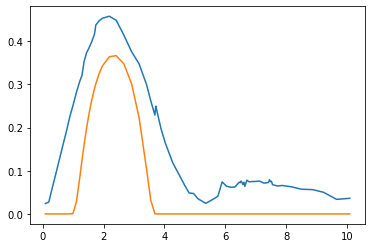

In [160]:
plt.plot(R, Sigma2/Sigma0)
plt.plot(R, window(R, R0, R1))

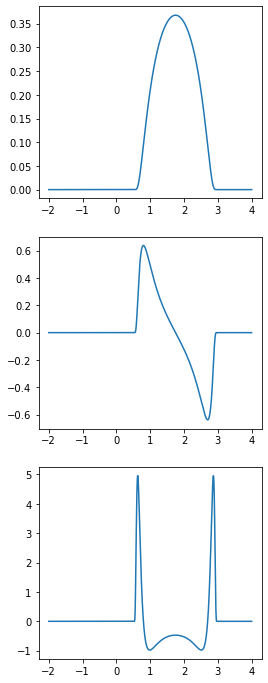

In [156]:
fig, ax = plt.subplots(3, 1, figsize=(4, 12))

x = np.linspace(-2, 4, 1000)
y = window(x, 0.5, 3)
yp = grad_window(x, 0.5, 3)
ypp = grad2_window(x, 0.5, 3)

ax[0].plot(x, y)
ax[1].plot(x, yp)
ax[2].plot(x, ypp)

### All snapshots

In [173]:
basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/psderiv/'

In [263]:
fname = basepath + 'iso/anlys/ps/ps_Nbody-lvl3.npy'
dat = np.load(fname, allow_pickle=True).item()

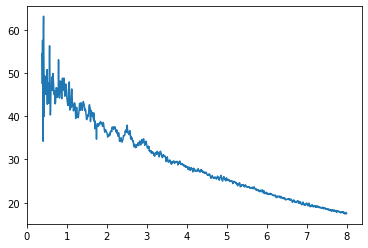

In [264]:
plt.plot(dat['time'], dat['ps'])

In [265]:
print(dat['ps'][500])
print(dat['ps'][501])
print(dat['ps'][502])

36.62150613596705
36.71969088470757
37.936289055203495


-0.20822808313615848


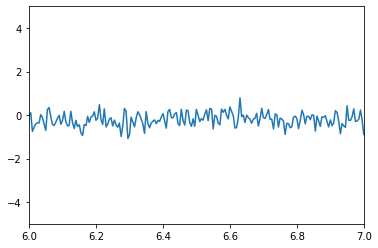

In [257]:
eta = - dat['psdot']/dat['ps']**2
plt.plot(dat['time'], eta)
plt.ylim(-5, 5)
plt.xlim(6, 7)
print(np.mean(eta[1200:1400]))

(-0.1, 0.1)

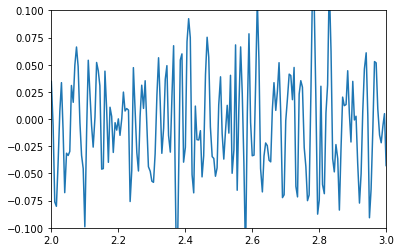

In [234]:
plt.plot(dat['time'], np.gradient(dat['ps'], dat['time'])/dat['ps']**2)
plt.xlim(2, 3)
plt.ylim(-0.1, 0.1)

(-1000.0, 1000.0)

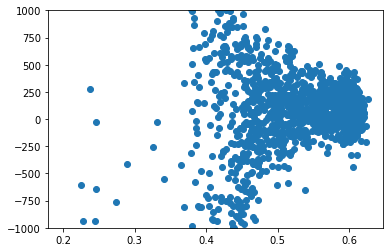

In [203]:
plt.scatter(dat['A2max'], dat['psdot'])
plt.ylim(-1000, 1000)